<a href="https://colab.research.google.com/github/artu134/NN_Reinforsed/blob/master/LSTMv1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [38]:
!git clone https://github.com/artu134/NN_Reinforsed.git

fatal: destination path 'NN_Reinforsed' already exists and is not an empty directory.


In [39]:
from NN_Reinforsed.Generator.tidal_waves_gen import Generator
import datetime

coordinates = (37.7749,-122.4194)#(lat,lon) San Francisco
start_date =  datetime.datetime.strptime('2023-05-10','%Y-%m-%d') # Start date (YYYY-MM-DD)
days = 28*40

# Generate tidal data
generator = Generator(coordinates[0], coordinates[1])
tidal_data = generator.get_tidal_data(start_date, days)

In [40]:
tidal_force = list(map(lambda row:[row[1]],tidal_data))

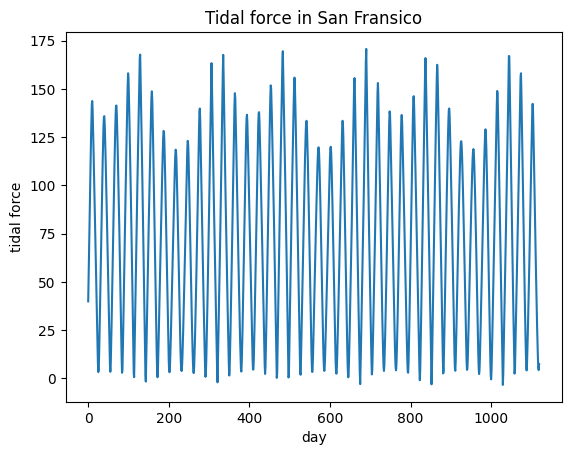

In [41]:
from matplotlib import pyplot as plt
%matplotlib inline

plt.plot(tidal_force)
plt.title("Tidal force in San Fransico")
plt.xlabel("day")
plt.ylabel("tidal force")
plt.show()

Based on the chart we can see two different cycles. Shorter ones are moon phases, and bigger one is Sun phase. Also  there seems to be the third one because there is diffenece in Sun phases

In [42]:
window_size = 28*4
prediction_size = 28

# Data preprocessing

In [43]:
train_end = int(len(tidal_force)*0.6)
val_end = train_end + int(len(tidal_force)*0.2)
train_raw = tidal_force[:train_end]
val_raw = tidal_force[train_end:val_end]
test_raw = tidal_force[val_end:]

In [44]:
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler()

In [45]:
import numpy as np
training_set_raw_scaled = sc.fit_transform(train_raw)

X_train = []
y_train = []
for i in range(window_size, len(training_set_raw_scaled)):
    if i+prediction_size > len(training_set_raw_scaled):
      break
    X_train.append(training_set_raw_scaled[i-window_size:i])
    y_train.append(training_set_raw_scaled[i:i+prediction_size])
X_train, y_train = np.array(X_train), np.array(y_train)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [46]:
X_train.shape, y_train.shape

((533, 112, 1), (533, 28, 1))

In [47]:
val_set_raw_scaled = sc.transform(val_raw)

X_val = []
y_val = []
for i in range(window_size, len(val_set_raw_scaled)):
    if i+prediction_size > len(val_set_raw_scaled):
      break
    X_val.append(val_set_raw_scaled[i-window_size:i])
    y_val.append(val_set_raw_scaled[i:i+prediction_size])
X_val, y_val = np.array(X_val), np.array(y_val)

X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1))

In [48]:
X_val.shape, y_val.shape

((85, 112, 1), (85, 28, 1))

# Model creation

In [51]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

regressor = Sequential()

regressor.add(LSTM(units = 512, 
                   activation='relu',
                   return_sequences = True, 
                   input_shape = (X_train.shape[1], 1)))

#mdl.add(LSTM(64, return_sequences=True))
regressor.add(LSTM(64, return_sequences=False))
#regressor.add(Dropout(0.2))

#regressor.add(LSTM(units = 50, return_sequences = True))
#regressor.add(Dropout(0.25))

#regressor.add(LSTM(units = 50, return_sequences = True))
#regressor.add(Dropout(0.25))

#regressor.add(LSTM(units = 50))   
#regressor.add(Dropout(0.25))

regressor.add(Dense(units = prediction_size,activation='linear'))

regressor.compile(optimizer = 'adam', loss = 'mean_absolute_error')


# Model Training

In [52]:
history = regressor.fit(X_train, y_train, validation_data=(X_val,y_val), epochs = 50, batch_size = 32)

Epoch 1/50
17/17 [==============================] - 9s 293ms/step - loss: 0.3162 - val_loss: 0.2656
Epoch 2/50
17/17 [==============================] - 3s 186ms/step - loss: 0.2323 - val_loss: 0.2434
Epoch 3/50
17/17 [==============================] - 3s 186ms/step - loss: 0.2063 - val_loss: 0.1716
Epoch 4/50
17/17 [==============================] - 3s 186ms/step - loss: 0.1087 - val_loss: 0.0960
Epoch 5/50
17/17 [==============================] - 5s 284ms/step - loss: 0.0577 - val_loss: 0.0618
Epoch 6/50
17/17 [==============================] - 3s 193ms/step - loss: 0.0467 - val_loss: 0.0569
Epoch 7/50
17/17 [==============================] - 3s 190ms/step - loss: 0.0432 - val_loss: 0.0453
Epoch 8/50
17/17 [==============================] - 5s 283ms/step - loss: 0.0400 - val_loss: 0.0487
Epoch 9/50
17/17 [==============================] - 3s 194ms/step - loss: 0.0384 - val_loss: 0.0485
Epoch 10/50
17/17 [==============================] - 3s 195ms/step - loss: 0.0359 - val_loss: 0.0569

Text(0.5, 1.0, 'Loss')

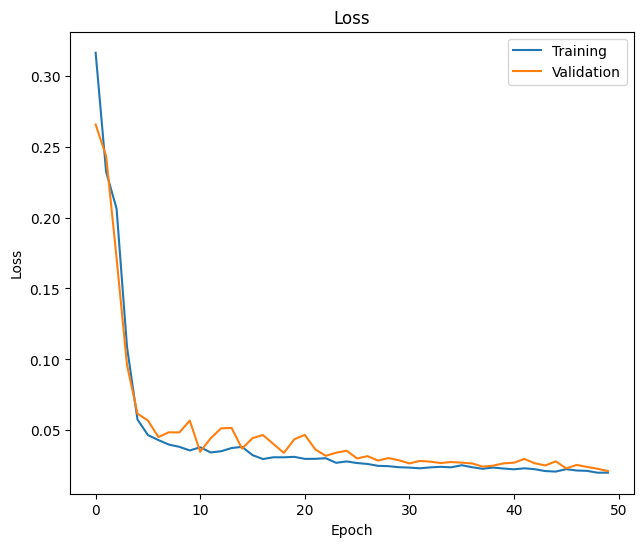

In [53]:
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training', 'Validation'])
plt.title('Loss')

# Evaluation

In [54]:
test_set_raw_scaled = np.concatenate([val_set_raw_scaled[-window_size:], sc.transform(test_raw)])
X_test = []
for i in range(window_size, len(test_set_raw_scaled)):
    X_test.append(test_set_raw_scaled[i-window_size:i])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_norm = regressor.predict(X_test)
predicted = sc.inverse_transform(predicted_norm)

7/7 [==============================] - 1s 23ms/step


In [55]:
X_test.shape,predicted_norm.shape

((224, 112, 1), (224, 28))

In [56]:
predicted.shape

(224, 28)

In [57]:
np.array(test_raw).shape

(224, 1)

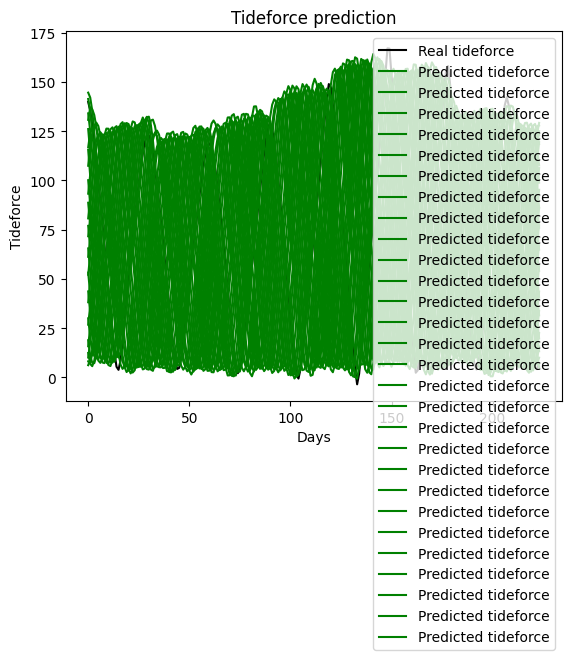

In [62]:
plt.plot(test_raw, color = 'black', label = 'Real tideforce')
plt.plot(predicted, color = 'green', label = 'Predicted tideforce')
plt.title('Tideforce prediction')
plt.xlabel('Days')
plt.ylabel('Tideforce')
plt.legend()
plt.show()

In [97]:
input_window = val_set_raw_scaled[-window_size:].tolist()
predictions = []
for val in test_raw:
  input = np.array([input_window],dtype=np.float64)
  predicted_norm = regressor.predict(input)
  predicted = sc.inverse_transform(predicted_norm)
  val=predicted.reshape((28))
  predictions.append(val)
  
  input_window.append(val)
  input_window.pop(0)
  break

1/1 [==============================] - 0s 150ms/step


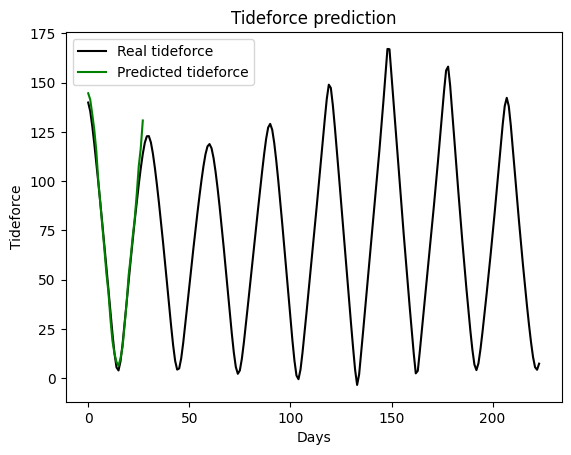

In [104]:
plt.plot(test_raw, color = 'black', label = 'Real tideforce')
plt.plot(predictions[0], color = 'green', label = 'Predicted tideforce')
plt.title('Tideforce prediction')
plt.xlabel('Days')
plt.ylabel('Tideforce')
plt.legend()
plt.show()